In [1]:
!pip install transformers
!pip install cleanlab

     |████████████████████████████████| 3.5 MB 8.2 MB/s 
     |████████████████████████████████| 6.8 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 31.6 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 77 kB 2.0 MB/s 


In [2]:
import gc
import os
from collections import Counter
import torch
import pandas as pd
import numpy as np
from transformers import AutoModel, AdamW, AutoTokenizer
from scipy.stats import rankdata
from sklearn import metrics
from google.colab import drive

In [3]:
path_drive = '/content/drive'
path_data = os.path.join(path_drive, 'MyDrive','Colab\ Notebooks', 'kaggle', 'data')
drive.mount(path_drive)

Mounted at /content/drive


In [4]:
%cp {path_data} -r ./
!git clone https://github.com/jespinosal/nlp_tools.git
%cd nlp_tools/

Cloning into 'nlp_tools'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 79 (delta 42), reused 66 (delta 29), pack-reused 0
Unpacking objects: 100% (79/79), done.
/content/nlp_tools


In [5]:
from config import ConfigSeq2SeqMultiLabel
from parser.datasets import DataSetSeq2SeqMultiLabel
from models.classifiers import RobertaMultiLabel
from torch_utils.trainer import train_epoch, fit
from torch_utils.eval import eval
from torch_utils.inference import predict
from torch_utils.utils import set_seed, get_device, set_cv_dataset_partitions, get_data_loaders

In [6]:
class Config(ConfigSeq2SeqMultiLabel):
  DEVICE = get_device()
  # data
  LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
  #TEXT_COLUMN =  'comment_text'
  PARITION_COLUMN = 'k_fold'
  # model
  MODEL_NAME = 'roberta-base'
  MODEL_DROPOUT = 0.2
  MODEL_HIDDEN_STATES = 768
  MODEL_LABELS = len(LABEL_COLUMNS)
  # tokenizer
  MAX_LENGTH = 128
  # train
  TRAIN_BATCH_SIZE = 64 
  LEARNING_RATE = 3e-5
  EVAL_BATCH_SIZE = 64
  TEST_BATCH_SIZE = 64
  EPOCHS = 3 
  N_FOLDS = 3

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


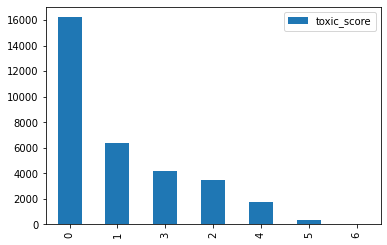

In [7]:
# Read data
df_multi_label = pd.read_csv("/content/data/jigsaw-toxic-comment-classification-challenge/train.csv")
df_val = pd.read_csv("/content/data//jigsaw-toxic-severity-rating/validation_data.csv")
df_submmit = pd.read_csv("/content/data/jigsaw-toxic-severity-rating/comments_to_score.csv")

# Assign multi label tags for stratified parition
y_tags = [str(y_values) for y_values in  df_multi_label[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values]
y_tags_2_idx = dict(Counter(y_tags))
df_multi_label['tag_idx'] = [(y_tags_2_idx[y_tag]) for y_tag in y_tags]

# Perform random under sampling: hypothesis we cannot assume order of toxitixity level because the space of categories is biased beacuse of the annotators subjectivity
df_multi_label['toxic_score'] = df_multi_label[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
df_multi_label_toxic = df_multi_label.loc[df_multi_label['toxic_score']>0]
df_multi_label_non_toxic = df_multi_label.loc[df_multi_label['toxic_score']==0].sample(n=len(df_multi_label_toxic), random_state=41)
df_multi_label = pd.concat([df_multi_label_non_toxic, df_multi_label_toxic]).reset_index(drop=True)

# Create K fold partitions
df_multi_label['tag_idx'] = df_multi_label['tag_idx'].astype(str)
df_multi_label = set_cv_dataset_partitions(df=df_multi_label, k_folds=Config.N_FOLDS, seed=100, stratify_column='tag_idx')


# Check sentiment distribution
df_multi_label.toxic_score.value_counts().to_frame().plot.bar()

In [8]:
# Get train components
model = RobertaMultiLabel(config=Config)
model.to(Config.DEVICE)
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean') # combines Sigmoid layer + BCE 
optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [9]:
# Prepare submit data
df_torch_submmit = DataSetSeq2SeqMultiLabel(df=df_submmit, tokenizer=tokenizer, config=Config, inference_mode=True, text_column='text')
data_loader_submmit = torch.utils.data.DataLoader(df_torch_submmit, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=2, shuffle=False, pin_memory=True, drop_last=False)

# Execute training and inference
preds_multi_label = pd.DataFrame()
score_toxic_classification = []
score_toxic_ranking= []
for kfold in range(Config.N_FOLDS):
    # GET DATA LOADERS
    gc.collect()
    train_loader, val_loader = get_data_loaders(df=df_multi_label, df_torch_parser=DataSetSeq2SeqMultiLabel,
                                                config=Config, tokenizer=tokenizer, kfold=kfold,
                                                text_column='comment_text')
    # TRAIN K FOLD MODEL
    gc.collect()
    best_model, history_log = fit(model=model, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader,
                                  loss_fn=loss_fn, device=Config.DEVICE, epochs=Config.EPOCHS,
                                  model_path=f'model_multi_{kfold}.bin', scheduler=scheduler)

    # PERFORM SUBMIT PREDICTION
    gc.collect()
    predictions_multilabel = np.array(predict(model=best_model, data_loader=data_loader_submmit, device=Config.DEVICE))
    cv_preds = predictions_multilabel.mean(axis=1)
    preds_multi_label[f'kfold_{kfold}'] = cv_preds

    # VALIDATE TEST DATASET FOR TOXIC CLASSIFICATION
    gc.collect()
    class_threshold = 0.3
    predictions, targets = eval(model=best_model, data_loader=val_loader, device=Config.DEVICE)
    outputs = np.array(predictions) >= class_threshold
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    score_toxic_classification.append(f1_score_micro)

    # VALIDATE TEST DATASET FOR TOXIX RANKING
    gc.collect()
    df_torch_val_less_toxic = DataSetSeq2SeqMultiLabel(df=df_val, tokenizer=tokenizer,config=Config, inference_mode=True, text_column='less_toxic')
    data_loader_val_less_toxic= torch.utils.data.DataLoader(df_torch_val_less_toxic, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True, drop_last=False)
    df_torch_val_more_toxic = DataSetSeq2SeqMultiLabel(df=df_val, tokenizer=tokenizer,config=Config, inference_mode=True, text_column='more_toxic')
    data_loader_val_more_toxic = torch.utils.data.DataLoader(df_torch_val_more_toxic, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True, drop_last=False)                                
    predictions_multilabel_less_toxic = np.array(predict(model=best_model, data_loader=data_loader_val_less_toxic, device=Config.DEVICE))
    predictions_multilabel_more_toxic = np.array(predict(model=best_model, data_loader=data_loader_val_more_toxic, device=Config.DEVICE))
    predictions_multilabel_less_toxic = predictions_multilabel_less_toxic.mean(axis=1)
    predictions_multilabel_more_toxic = predictions_multilabel_more_toxic.mean(axis=1)
    metric = np.mean(predictions_multilabel_less_toxic < predictions_multilabel_more_toxic)
    score_toxic_ranking.append(metric)

print('--Toxic classification kcf results--', score_toxic_classification) 
print(f'--mean: {np.mean(score_toxic_classification)} --- std {np.std(score_toxic_classification)}') 
print('--Toxic ranking kcf results--', score_toxic_ranking)   
print(f'--mean: {np.mean(score_toxic_ranking)} --- std {np.std(score_toxic_ranking)}') 

100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


{'epoch': 0, 'train_loss:': 0.20485947600160354, 'val_loss': 0.15837427099809026}


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


{'epoch': 1, 'train_loss:': 0.14709459055862262, 'val_loss': 0.15806426636387705}


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


{'epoch': 2, 'train_loss:': 0.14563150778919098, 'val_loss': 0.15834029931053306}


100%|██████████| 170/170 [00:41<00:00,  4.05it/s]


{'epoch': 0, 'train_loss:': 0.1494090172042375, 'val_loss': 0.13714052751740247}


100%|██████████| 170/170 [00:41<00:00,  4.05it/s]


{'epoch': 1, 'train_loss:': 0.12720639153124463, 'val_loss': 0.1388374765470424}


100%|██████████| 170/170 [00:41<00:00,  4.07it/s]


{'epoch': 2, 'train_loss:': 0.13210018396464354, 'val_loss': 0.16734949845110442}


100%|██████████| 169/169 [00:41<00:00,  4.03it/s]


{'epoch': 0, 'train_loss:': 0.13974076878147546, 'val_loss': 0.12354281566728502}


100%|██████████| 169/169 [00:41<00:00,  4.03it/s]


{'epoch': 1, 'train_loss:': 0.12133495699591212, 'val_loss': 0.12890797355294933}


100%|██████████| 169/169 [00:41<00:00,  4.04it/s]


{'epoch': 2, 'train_loss:': 0.12749472164940764, 'val_loss': 0.12644151329288822}


100%|██████████| 471/471 [03:19<00:00,  2.36it/s]

--Toxic classification kcf results-- [0.8103777184280809, 0.8278005153857814, 0.8442309874068751]
--mean: 0.8274697404069125 --- std 0.013822518202860887
--Toxic ranking kcf results-- [0.6804171648731234, 0.6851003055666268, 0.6805500199282583]
--mean: 0.6820224967893362 --- std 0.0021770151995479598


## MODEL EVALUATION

In [18]:
# Perform submission
preds_multi_label = preds_multi_label[[f'kfold_{kfold}' for kfold in range(0, Config.N_FOLDS)]].mean(axis=1)
df_submmit['score'] = preds_multi_label
df_submmit[['comment_id', 'score']].to_csv("submission.csv", index=False)
# df_submmit['score'] = rankdata(preds_multi_label,  method='ordinal')
print(df_submmit.head(25))


    comment_id                                               text     score
0       114890  "\n \n\nGjalexei, you asked about whether ther...  0.006622
1       732895  Looks like be have an abuser , can you please ...  0.056845
2      1139051  I confess to having complete (and apparently b...  0.020358
3      1434512  "\n\nFreud's ideas are certainly much discusse...  0.005044
4      2084821  It is not just you. This is a laundry list of ...  0.219431
5      2452675  HectorRodriguez added blatant NPOV comments to...  0.019417
6      3206615  "\n\n baiting Paul \n\nI don't think its entir...  0.133303
7      3665348  "\nTesla stuff\n\nNotice how all those ""ugly ...  0.097394
8      4502494  Shoot! I can't find where i found that instanc...  0.006260
9      4804786  Just because one is gay does not mean one is u...  0.177517
10     4974702   Todo speedy deletion candidates \n\nI do not ...  0.008434
11     5407955  "Just for the record, Castro apologised for hi...  0.111463
12     57608

In [21]:
# Multilabel output example for submit
predictions_multilabel[[0,1,16,24]]

array([[0.01626703, 0.00165017, 0.0043551 , 0.00172457, 0.00343786,
        0.00238258],
       [0.42570814, 0.00153706, 0.00996141, 0.00316186, 0.0237157 ,
        0.0050201 ],
       [0.95442867, 0.00650377, 0.1050578 , 0.00322293, 0.70317334,
        0.01263599],
       [0.96662068, 0.02292856, 0.06799743, 0.17076905, 0.27874207,
        0.41396749]])